Get AgeAnalysisData1.pickle and AgeAnalysisData2.pickle: https://drive.google.com/drive/folders/1Q_DZT6ELtnieUQPfduH2JxIWypQYSEcV?usp=sharing

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import time

In [2]:
def reviewsByGrade(URL, reviews_by_grade, years_by_grade, grades_by_year, grades_by_review):
    '''
        This function takes a URL from the section of robertchristgau.com that lists albums by their grade as input
        Then it scrapes the URL for its text before storing relevant data on grades, years, and artist/album names into 4 different dictionaries
    
        Input: a URL, 4 empty dictionaries
        
        Output: nothing
        
        Modifies: 4 different dictionaries that aggregate data on grades, years, and artist/album names
    '''
    
    text = BeautifulSoup(requests.get(URL).content, "html.parser").get_text().split("\n") # get just the text from the URL
    
    try:
        text = text[text.index('Follow @rxgau')+5:text.index('Consumer Guide Index by Grade')]
        
    except:
        print(f"There's been an error, the following page is formatted differently than the rest: {URL}")

    try:
        text.remove('Compilations/Soundtracks')
        
    except:
        pass

    reviews = [] # get reviews for one grade

    for i in range(1, len(text)-1):
        if (text[i] != '') and (text[i+1] != ''):
            reviews.append(text[i] + " " + text[i+1]) # to get the albums
            
        elif (text[i-1] == '') and (text[i] != '') and (text[i+1] == ''):
            reviews.append(text[i]) # to get the compliations/soundtracks, which are only on one line

    reviews[0] = reviews[0].replace('Consumer Guide Grade List: ', '').split(' ', 1)[0] # pull the grade

    grade = reviews[0]
    reviews = reviews[1:]
    
    # convert *** to B, ** to B-, * to C+, N to C, S to C-, X to D+ - logic assumed from here: https://www.robertchristgau.com/xg/bk-cg90/grades-90s.php
    if grade == '***':
        grade = 'B+'
    if grade == '**':
        grade = 'B'
    if grade == '*':
        grade = 'B-'
    if grade == 'N':
        grade = 'B-'
    if grade == 'S':
        grade = 'C+'
    if grade == 'X':
        grade = 'C+'

    reviews_parsed = []
    years = []
    
    for review in reviews:
        try:
            reviews_parsed.append((review.split(' [')[0], # get the artist and album
                                   int(review.split(' [')[1].split(',')[0]))) # get the year and make it an integer
            
            grades_by_review[(review.split(' [')[0],
                                   int(review.split(' [')[1].split(',')[0]))] = grade
            
            if int(review.split(' [')[1].split(',')[0]) not in grades_by_year:
                grades_by_year[int(review.split(' [')[1].split(',')[0])] = [grade]
            else:
                grades_by_year[int(review.split(' [')[1].split(',')[0])].append(grade)
            
            years.append(int(review.split(' [')[1].split(',')[0][:4]))
            
        except Exception as e: # for the cases in which the album name has a '[' in it (ex. Prince and the New Power Generation: [File Under Prince] [1992, Paisley Park])
            if ("-" in str(e)): # for the very 3-4 cases in which the year is mistakenly written as something like 1999-0 on the site
                pass
            elif 'invalid literal' in str(e): 
                reviews_parsed.append(((' ['.join(review.split(' [')[:2]), 
                                        int(' ['.join(review.split(' [')[2:]).split(',')[0]))))
                                       
                grades_by_review[((' ['.join(review.split(' [')[:2]), 
                                   int(' ['.join(review.split(' [')[2:]).split(',')[0][:4])))] = grade
                
                if int(' ['.join(review.split(' [')[2:]).split(',')[0]) not in grades_by_year:
                    grades_by_year[int(' ['.join(review.split(' [')[2:]).split(',')[0][:4])] = [grade]
                else:
                    grades_by_year[int(' ['.join(review.split(' [')[2:]).split(',')[0][:4])].append(grade)
                
                years.append(int(' ['.join(review.split(' [')[2:]).split(',')[0]))
                
            else: # deal with other errors manually
                print(f'error type: {e}')
                print(f'grade: {grade}')
                print(f'URL: {URL}')
                print(f'review text: {review}')
                print()
    
    if grade not in reviews_by_grade:
        reviews_by_grade[grade] = reviews_parsed
        years_by_grade[grade] = years
        
    else: # this is so we add the "star" reviews to the converted grades   
        reviews_by_grade[grade] = reviews_by_grade[grade] + reviews_parsed

In [3]:
# these are the relevant URLs that we will feed into the function reviewsByGrade
URLs = ["https://www.robertchristgau.com/get_gl.php?g=A%2B", #A+
        "https://www.robertchristgau.com/get_gl.php?g=A", #A
        "https://www.robertchristgau.com/get_gl.php?g=A-", #A-
        "https://www.robertchristgau.com/get_gl.php?g=B%2B", #B+
        "https://www.robertchristgau.com/get_gl.php?g=B", #B
        "https://www.robertchristgau.com/get_gl.php?g=***", #B+
        "https://www.robertchristgau.com/get_gl.php?g=B-", #B-
        "https://www.robertchristgau.com/get_gl.php?g=**", #B
        "https://www.robertchristgau.com/get_gl.php?g=C%2B", #C+
        "https://www.robertchristgau.com/get_gl.php?g=*", #B-
        "https://www.robertchristgau.com/get_gl.php?g=C", #C
        "https://www.robertchristgau.com/get_gl.php?g=N", #B- "neither"
        "https://www.robertchristgau.com/get_gl.php?g=C-", #C-
        "https://www.robertchristgau.com/get_gl.php?g=S", #C+ - "choice cut" Christgau says these are most likely "bombs (X)", which I think is equivalent to a C+
        "https://www.robertchristgau.com/get_gl.php?g=D%2B", #D+
        "https://www.robertchristgau.com/get_gl.php?g=X", #C+ "bombs"
        "https://www.robertchristgau.com/get_gl.php?g=D", #D
        "https://www.robertchristgau.com/get_gl.php?g=D-", #D-
        "https://www.robertchristgau.com/get_gl.php?g=E%2B", #E+
        "https://www.robertchristgau.com/get_gl.php?g=E", #E
        "https://www.robertchristgau.com/get_gl.php?g=E-"] #E-

In [4]:
# create four separate dictionarys
# we might not end up using all of them, but since we only have to call this once, it's worth the extra computation time just in case we want different representations of the data
# dictionaries are mutable, so our function will modify these without us needing to return anything

reviews_by_grade = {}
years_by_grade = {}
grades_by_year = {}
grades_by_review = {}

In [5]:
# let's time how long it takes to scrape all these URLs!
start_time = time.time()

for URL in URLs: # this loop is doing all the work
    reviewsByGrade(URL, reviews_by_grade, years_by_grade, grades_by_year, grades_by_review)

print()
print()
print(f"It took {time.time() - start_time} seconds to scrape all that data and create 4 dictionaries to store it!")

error type: list index out of range
grade: B+
URL: https://www.robertchristgau.com/get_gl.php?g=B%2B
review text: Tim Heidecker: Too Dumb for Suicide: Tim Heidecker's Trump



It took 11.62314486503601 seconds to scrape all that data and create 4 dictionaries to store it!


In [6]:
'''
    Since we only have one error left, we might as well resolve it manually
    
    But we also note that...writing all of this was a bit of a pain, and to fix even one error, we have to edit 4 of the dictionaries that we made
    Lesson learned. For the second part of our analysis and scraping, we only build one dictionary, and then modify it after the data is collected if necessary
    
    And we also consider the fact that we don't need ALL of the data from the site...
    Just a significant enough representation to make an informed test of our hypothesis
'''

reviews_by_grade["B+"] = reviews_by_grade["B+"] + [("Tim Heidecker: Too Dumb for Suicide: Tim Heidecker's Trump Songs", 2017)]
grades_by_review[("Tim Heidecker: Too Dumb for Suicide: Tim Heidecker's Trump Songs", 2017)] = "B+"
grades_by_year[2017].append("B+")
years_by_grade["B+"].append(2017)

In [7]:
# save data
'''
with open('AgeAnalysisData1.pickle', 'wb') as handle:
    pickle.dump(reviews_by_grade, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('AgeAnalysisData2.pickle', 'wb') as handle:
    pickle.dump(grades_by_year, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''
# load data
'''
with open('AgeAnalysisData1.pickle', 'rb') as handle:
    reviews_by_grade = pickle.load(handle)
with open('AgeAnalysisData2.pickle', 'rb') as handle:
    grades_by_year = pickle.load(handle)
'''

"\nwith open('AgeAnalysisData1.pickle', 'rb') as handle:\n    reviews_by_grade = pickle.load(handle)\nwith open('AgeAnalysisData1.pickle', 'rb') as handle:\n    grades_by_year = pickle.load(handle)\n"

Up until this point, we've collected all of the data we need from robertchristgau.com and packed it into dictionaries.

Now, we perform an analysis to test a hunch I've had after a few years reading Christgau's album reviews - that he's gotten more lenient in his album scoring as the years go by.

Formally:
- Null hypothesis: No significant positive trend exists
- Alternative hypothesis: A significant positive trend exists

In [8]:
'''
for now, we only want grades_by_year in order to test our hypothesis
taking a peek at its keys, we notice an incorrect entry - 136 is not a valid year
after a manual check at the website, it looks like the year was wrong on the site itself (it was not an issue with our code)
we drop the value
'''

display(sorted(list(grades_by_year.keys()))[0:5])
display(sorted(list(grades_by_year.keys()))[-5:])

del grades_by_year[136]
display(sorted(list(grades_by_year.keys()))[0:5])

[136, 1960, 1962, 1964, 1967]

[2017, 2018, 2019, 2020, 2021]

[1960, 1962, 1964, 1967, 1968]

In [9]:
# make a data frame for easier viewing
years_df = pd.DataFrame.from_dict(grades_by_year, orient='index').transpose()
years_df = years_df.reindex(sorted(years_df.columns), axis=1)

In [10]:
years_df.head(3)

,1960,1962,1964,1967,1968,1969,1970,1971,1972,1973,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,A,A-,A-,A+,A-,A+,A+,A+,A+,A+,...,A,A+,A+,A+,A+,A,A+,A,A+,A
1,None,None,None,A,B,A+,A+,A+,A+,A+,...,A,A,A,A,A,A,A,A,A+,A
2,None,None,None,A,B-,A+,A+,A+,A+,A,...,A,A,A,A,A,A,A,A,A,A


In [11]:
grades = {"A+":97,
          "A":93,
          "A-":90,
          "B+":87,
          "B":83,
          "B-":80,
          "C+":77,
          "C":73,
          "C-":70,
          "D+":67,
          "D":63,
          "D-":60,
          "E+":57,
          "E":53,
          "E-":50}

In [12]:
# quantify the grades for analysis
years_df_numerical = years_df.replace(grades)

In [13]:
# we notice that some years have very few reviews
# let's drop the years that have fewer than 30 reviews
years_df_numerical = years_df_numerical[years_df_numerical.columns[years_df_numerical.isnull().mean() < 0.8]]

In [14]:
means = pd.DataFrame(years_df_numerical.mean()).reset_index().rename(columns={'index': 'year',0: 'mean'})

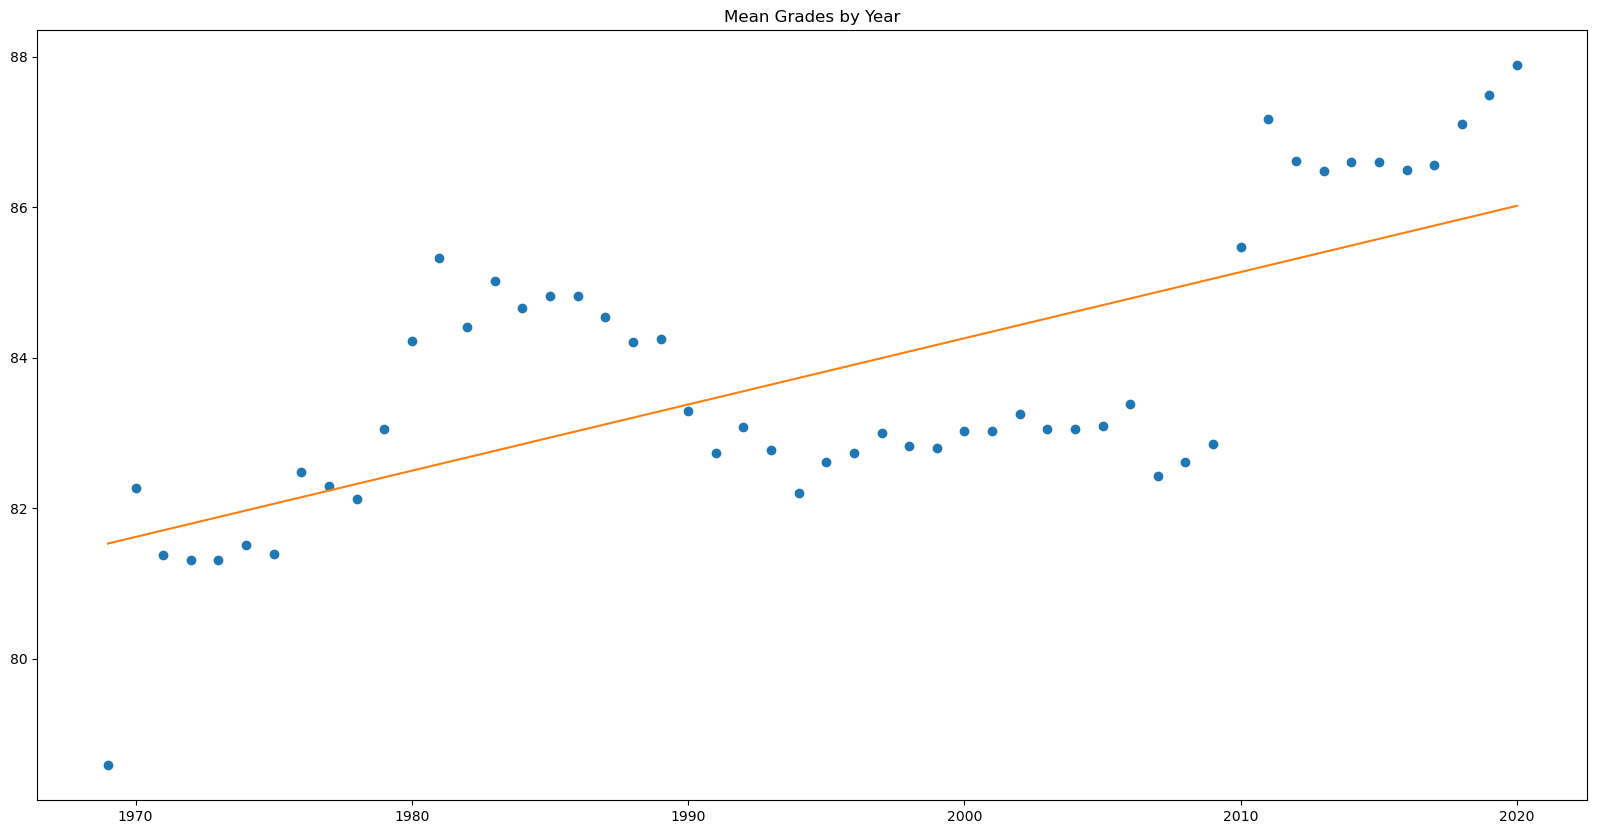

In [15]:
# let's visualize the mean distribution of scores across years
plt.figure(figsize=(20,10))
plt.title('Mean Grades by Year')

x, y = means['year'], means['mean']

#create basic scatterplot
plt.plot(x, y, 'o')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b)

plt.show()

In [16]:
r = np.corrcoef(x, y)[0,1]
display(f"correlation coefficient = {r}")

'correlation coefficient = 0.684812277693051'

A correlation coefficient of approximately 0.68 represents a moderate to strong correlation between year and grade. Both visually and numerically, we believe there is a trend.

Let's now test our null hypothesis a bit more formally with a Tau-test (https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient). Kendall's Tau is a statistic that measures the ordinal association between two variables, which is exactly what we want to use to test if there is a statistically significant trend in our time series

In [17]:
import scipy.stats as stats
tau, p_value = stats.kendalltau(means['year'], means['mean'])

In [18]:
print(f"Kendall's Tau: {tau}, p-value: {p_value}")

Kendall's Tau: 0.46757164404223234, p-value: 9.95796558607817e-07


In [19]:
p_value < 0.05

True

Since our Tau coefficient is positive (indicating a positive correlation) and our p-value is beneath 0.05, we have enough evidence to reject our null hypothesis and say that Christgau has gotten more lenient in his album grading over the years. Why? We can only speculate - our test tells us nothing about that. Maybe music has gotten better since the 70s (doubtful), or the increased access to music with the advent of streaming has forced Christgau to being more selective in choosing which albums to review (a selection bias due to choice overload).